<a href="https://colab.research.google.com/github/msoley/CSCI-535/blob/main/multimodal_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audiovisual Emotion Recognition
In this practicum, we play with features extracted from a subset of [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D) a dataset for emotion recognition. It features actors portraying expressions of emotions, namely, happiness, sadness, anger, fear, disgust, and neutral, with both their facial expressions and voices recorded.   This database is useful for performing audiovisual emotion recognition and the prototypical expressions are portrayed. The dataset comes with pre-defined train, test and validation sets. We have extracted two feature sets from a randomely selected subset of the dataset and prepared them for you. From the visual modality, we extracted the displayed facial action unit intensity estimates and head pose angles using [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace). For audio, we extracted [TRILL](https://blog.research.google/2020/06/improving-speech-representations-and.html) features that come from a pretrained model.


In [ ]:
#download and extract the bundled features
!wget https://ict.usc.edu/~soleymani/subsampled.zip
import zipfile
import os
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)
features_path = './subsampled/'
!ls ./subsampled/

You can see that there are three feature sets: openface, trill and merged. The merged feature set contains both openface and trill concatenated, which we can use for early fusion.

Let's import the necessary packages and define some constants

In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import pad_sequences
import random
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

FEATURE_SIZE_OPENFACE = 20
FEATURE_SIZE_TRILL = 512
MAX_LEN = 12
#define emotion labels and feature sets
labels_dict = {'ANG':0, 'DIS':1, 'FEA':2, 'HAP':3, 'NEU':4, 'SAD':5}
feature_sets = ['openface','trill', 'merged']

# Feature visualization
Let's look at some of the openface features to see whether they are useful and how discrimative they are. The features in the openface files are as follows:
['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r','AU07_r',                     'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',                     'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r' ,'AU45_r',                      'pose_Rx', 'pose_Ry', 'pose_Rz']

Look at the definition of facial action units [here](https://www.cs.cmu.edu/~face/facs.htm). Which ones are going to be useful? Try visualizing them by modifying the following code, or writing your own.



100%|██████████| 1106/1106 [00:00<00:00, 1860.32it/s]


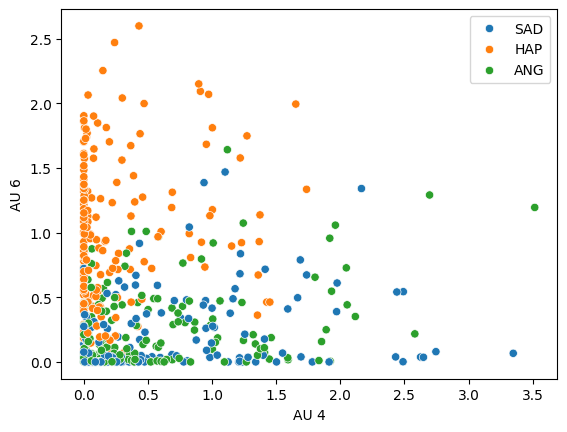

In [3]:

#load the npy files and extract the labels from the file name
def extract_label(file_name):
    return file_name.split('_')[2]
#let's do this only for train
all_files= os.listdir(os.path.join(features_path, feature_sets[0], 'train'))
pooled_data = []
labels = []
for npy_file in tqdm(all_files):
    data = np.load(os.path.join(features_path, feature_sets[0], 'train', npy_file))
    label = extract_label(npy_file)
    if label in ['ANG', 'SAD', 'HAP']:
        labels.append(label)
        pooled_data.append(data[:,[2,4]].mean(axis=0))
pooled_data = np.array(pooled_data)
pooled_data[pooled_data<0]=0 # reject outliers
#let's visualize the data
sns.scatterplot(x=pooled_data[:,0], y=pooled_data[:,1], hue=labels)
plt.xlabel("AU 4")
plt.ylabel("AU 6")
plt.show()


First, we need a data loader. Here is a data loader (generator) for a unimodal model, defined for tensorflow Keras.

In [4]:
#write a data generator for keras
random.seed(0)  # let's fix the seed so the results can be repeated
class SequenceDataGenerator(Sequence):
    """Custom data generator for loading and preprocessing NumPy files.

    Attributes:
        data_path: The path to the directory containing the NumPy files.
        x_filenames: List of filenames for the NumPy data files.
        y_labels: List of labels (optional), loaded from the CSV file.
        batch_size: The number of samples to yield in each batch.
        shuffle: Whether to shuffle the data during each epoch (default: True).
        n_channels: The number of channels/features in the data (default: 1).
        target_size: max length for padding or clipping.
        preprocessing_fn: An optional function to apply preprocessing to the data.
    """

    def __init__(self, data_path, labels_dict=None, batch_size=32, shuffle=True, n_channels=1, target_size=None, preprocessing_fn=None):
        self.data_path = data_path
        self.x_filenames = sorted([f for f in os.listdir(data_path) if f.endswith(".npy")])
        self.y_labels = np.asarray([labels_dict[f.split('_')[2]] for f in self.x_filenames])
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.target_size = target_size
        self.preprocessing_fn = preprocessing_fn

        if self.shuffle:
            shuffled_files = self.x_filenames.copy()
            shuffled_labels = self.y_labels.copy()
            indices = list(range(len(self.x_filenames)))
            random.shuffle(indices)
            for i, idx in enumerate(indices):
                shuffled_files[i] = self.x_filenames[idx]
                shuffled_labels[i] = self.y_labels[idx]
            self.x_filenames = shuffled_files
            self.y_labels = shuffled_labels

    def __len__(self):
        """Returns the number of batches in the dataset."""
        return int(np.ceil(len(self.x_filenames) / self.batch_size))

    def __getitem__(self, idx):
        """Generates one batch of data."""
        # Get list of filenames for this batch
        batch_filenames = self.x_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Load data (X) from NumPy files
        X = np.zeros((self.batch_size,self.target_size,self.n_channels))
        for i,filename in enumerate(batch_filenames):
            data = np.load(os.path.join(self.data_path, filename))
            if self.target_size:
                if data.shape[0] > self.target_size:
                    data = data[:self.target_size,:]
                elif data.shape[0] < self.target_size:
                    data = pad_sequences(data.T, maxlen=self.target_size, padding='post', dtype='float32', value=-1).T
            X[i,:,:] = data

                # Load labels (y) if provided
        y = None
        if self.y_labels is not None:
            y = self.y_labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Apply preprocessing function (optional)
        if self.preprocessing_fn:
            X = self.preprocessing_fn(X)
        if X.shape[0]>len(y):
            X=X[:len(y),:,:]
        return X, y  # Return data (X) and labels (y) if available

    def on_epoch_end(self):
        """Optionally shuffle data at the end of each epoch."""
        if self.shuffle:
            shuffled_files = self.x_filenames.copy()
            shuffled_labels = self.y_labels.copy()
            indices = list(range(len(self.x_filenames)))
            random.shuffle(indices)
            for i, idx in enumerate(indices):
                shuffled_files[i] = self.x_filenames[idx]
                shuffled_labels[i] = self.y_labels[idx]
            self.x_filenames = shuffled_files
            self.y_labels = shuffled_labels


Let's instantiate data loaders for openface splits.

In [5]:
#data generators (loaders) for openface
# Parameters for openface
params = {'data_path': os.path.join(features_path, feature_sets[0], 'train'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': True, 'n_channels': FEATURE_SIZE_OPENFACE, 'target_size':  MAX_LEN, 'preprocessing_fn': None}
train_generator_openface = SequenceDataGenerator(**params)

params = {'data_path': os.path.join(features_path, feature_sets[0], 'val'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': False, 'n_channels': FEATURE_SIZE_OPENFACE, 'target_size': MAX_LEN, 'preprocessing_fn': None}
val_generator_openface = SequenceDataGenerator(**params)

params = {'data_path': os.path.join(features_path, feature_sets[0], 'test'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': False, 'n_channels': FEATURE_SIZE_OPENFACE, 'target_size': MAX_LEN, 'preprocessing_fn': None}
test_generator_openface = SequenceDataGenerator(**params)

Define a unimodal model for ingesting a sequence (GRU)
 and classifying into six classes

In [6]:
# Define your model architecture here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

# Model definition
def build_gru_model(feature_size, num_classes):
    model = tf.keras.Sequential([
        #your model goes here
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Here we build, train and evaluate a unimodal model that uses openface features.

In [ ]:
NUM_CLASSES = 6  # Number of emotion categories

# Build and train the OpenFace model
model_openface = build_gru_model(FEATURE_SIZE_OPENFACE, NUM_CLASSES)
#model_openface.fit(train_ds_openface, epochs=5, validation_data=val_ds_openface)
#model_openface.evaluate(test_ds_openface)
model_openface.fit(train_generator_openface, epochs=5, validation_data=val_generator_openface)
results=model_openface.evaluate(test_generator_openface)
openface_preds = model_openface.predict(test_generator_openface)

print("test accuracy is {:.2f}".format(results[1]*100))

Let's instantiate data loaders for trill splits.

In [8]:
#data generators (loaders) for trill
# Parameters for trill
params = {'data_path': os.path.join(features_path, feature_sets[1], 'train'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': True, 'n_channels': FEATURE_SIZE_TRILL, 'target_size':  MAX_LEN, 'preprocessing_fn': None}
train_generator_trill = SequenceDataGenerator(**params)

params['shuffle'] = False # No need to shuffle for validation data
params = {'data_path': os.path.join(features_path, feature_sets[1], 'val'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': False, 'n_channels': FEATURE_SIZE_TRILL, 'target_size': MAX_LEN, 'preprocessing_fn': None}
val_generator_trill = SequenceDataGenerator(**params)

params['shuffle'] = False # No need to shuffle for test data
params = {'data_path': os.path.join(features_path, feature_sets[1], 'test'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': False, 'n_channels': FEATURE_SIZE_TRILL, 'target_size': MAX_LEN, 'preprocessing_fn': None}
test_generator_trill = SequenceDataGenerator(**params)

Repeat the same steps for trill

In [ ]:
# Build and train the TRILL model
model_trill = build_gru_model(FEATURE_SIZE_TRILL, NUM_CLASSES)
model_trill.fit(train_generator_trill, epochs=5, validation_data=val_generator_trill)
results = model_trill.evaluate(test_generator_trill)
trill_preds = model_trill.predict(test_generator_trill)
print("test accuracy is {:.2f}".format(results[1]*100))

Let's instantiate data loaders for early fusion (concatenated) splits.

In [10]:
#data generators (loaders) for early fusion
# Parameters for both
params = {'data_path': os.path.join(features_path, feature_sets[2], 'train'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': True, 'n_channels': FEATURE_SIZE_TRILL+FEATURE_SIZE_OPENFACE, 'target_size':  MAX_LEN, 'preprocessing_fn': None}
train_generator_ef = SequenceDataGenerator(**params)

params['shuffle'] = False # No need to shuffle for validation data
params = {'data_path': os.path.join(features_path, feature_sets[2], 'val'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': False, 'n_channels': FEATURE_SIZE_TRILL+FEATURE_SIZE_OPENFACE, 'target_size': MAX_LEN, 'preprocessing_fn': None}
val_generator_ef = SequenceDataGenerator(**params)

params['shuffle'] = False # No need to shuffle for test data
params = {'data_path': os.path.join(features_path, feature_sets[2], 'test'), 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': False, 'n_channels': FEATURE_SIZE_OPENFACE+FEATURE_SIZE_TRILL, 'target_size': MAX_LEN, 'preprocessing_fn': None}
test_generator_ef = SequenceDataGenerator(**params)

Let's define a simple model with one or two GRU layers for emotion recognition using concatenated features

In [11]:
# Model building function for early fusion
def build_ef_gru_model(input_shape, num_classes):
    model = tf.keras.Sequential([

        #your code goes here
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Build and train the early fusion model
model_ef = build_gru_model(FEATURE_SIZE_TRILL+FEATURE_SIZE_OPENFACE, NUM_CLASSES)
model_ef.fit(train_generator_ef, epochs=5, validation_data=val_generator_ef)
results = model_ef.evaluate(test_generator_ef)
print("test accuracy is {:.2f}".format(results[1]*100))

Any easy way for perform late fusion is to average the logits from unimodal models. We can do that using the trained trill and openface models. How does the performance compare the early fusion?

In [ ]:
#late fusion with two unimodal models

def predict_dataset(model, dataset):
    all_preds = []
    for features, _ in dataset:
        preds = model.predict(features)
        all_preds.append(preds)
    return np.concatenate(all_preds)

def calculate_late_fusion_accuracy(combined_preds, model_trill, test_generator_openface, test_generator_trill):
    # Predict with both models
    openface_preds = predict_dataset(model_openface, test_generator_openface)
    trill_preds = predict_dataset(model_trill, test_generator_trill)

    # Late fusion: averaging predictions
    combined_preds = (openface_preds + trill_preds) / 2

    val_labels = np.concatenate([y for _, y in test_generator_trill])

    predicted_labels = np.argmax(combined_preds, axis=1)
    accuracy = accuracy_score(val_labels, predicted_labels)
    print("Late Fusion Accuracy test accuracy is {:.2f}".format(accuracy*100))


calculate_late_fusion_accuracy(model_openface, model_trill, test_generator_openface, test_generator_trill)

# Fancy fusion
If you want to develop fancier fusion algorithms, you need a data loader that can yield separate batches of data for each modality. Here is one that can be used for this dataset.

In [14]:
#bimodal data loader
#this assumes that exactly the same file names exists for both modalities
random.seed(0)  # let's fix the seed so the results can be repeated
class SequenceDataGeneratorFusion(Sequence):
    """Custom data generator for loading and preprocessing NumPy files.

    Attributes:
        data_path: A list of two pathes to the directories containing the NumPy files.
        x_filenames: A List of filenames for the NumPy data files.
        y_labels: List of labels (optional), loaded from the CSV file.
        batch_size: The number of samples to yield in each batch.
        shuffle: Whether to shuffle the data during each epoch (default: True).
        n_channels: A list of numbers of channels/features in the data (default: 1).
        target_size: max length for padding or clipping.
        preprocessing_fn: An optional function to apply preprocessing to the data.
    """

    def __init__(self, data_path, labels_dict=None, batch_size=32, shuffle=True, n_channels=[1,1], target_size=None, preprocessing_fn=None):
        self.data_path = data_path
        self.x_filenames = sorted([f for f in os.listdir(data_path[0]) if f.endswith(".npy")])
        self.y_labels = np.asarray([labels_dict[f.split('_')[2]] for f in self.x_filenames])
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.target_size = target_size
        self.preprocessing_fn = preprocessing_fn

        if self.shuffle:
            shuffled_files = self.x_filenames.copy()
            shuffled_labels = self.y_labels.copy()
            indices = list(range(len(self.x_filenames)))
            random.shuffle(indices)
            for i, idx in enumerate(indices):
                shuffled_files[i] = self.x_filenames[idx]
                shuffled_labels[i] = self.y_labels[idx]
            self.x_filenames = shuffled_files
            self.y_labels = shuffled_labels

    def __len__(self):
        """Returns the number of batches in the dataset."""
        return int(np.ceil(len(self.x_filenames) / self.batch_size))

    def __getitem__(self, idx):
        """Generates one batch of data."""
        # Get list of filenames for this batch
        batch_filenames = self.x_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Load data (X) from NumPy files
        X = [np.zeros((self.batch_size,self.target_size,self.n_channels[j])) for j in range(len(self.data_path))]
        for i,filename in enumerate(batch_filenames):
            data = [np.load(os.path.join(self.data_path[j], filename)) for j in range(len(self.data_path))]
            if self.target_size:
                for j in range(2):
                    if data[j].shape[0] > self.target_size:
                        data[j] = data[j][:self.target_size,:]
                    elif data[j].shape[0] < self.target_size:
                        data[j] = pad_sequences(data[j].T, maxlen=self.target_size, padding='post', dtype='float32', value=-1).T
            for j in range(len(self.data_path)):
                X[j][i,:,:] = data[j]

        y = None
        if self.y_labels is not None:
            y = self.y_labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Apply preprocessing function (optional)
        if self.preprocessing_fn:
            for j in range(len(self.data_path)):
                X[j] = self.preprocessing_fn(X[j])
        for j in range(len(self.data_path)):
            if X[j].shape[0]>len(y):
                X[j]=X[j][:len(y),:,:]
        return X, y  # Return data (X) and labels (y) if available

    def on_epoch_end(self):
        """Optionally shuffle data at the end of each epoch."""
        if self.shuffle:
            shuffled_files = self.x_filenames.copy()
            shuffled_labels = self.y_labels.copy()
            indices = list(range(len(self.x_filenames)))
            random.shuffle(indices)
            for i, idx in enumerate(indices):
                shuffled_files[i] = self.x_filenames[idx]
                shuffled_labels[i] = self.y_labels[idx]
            self.x_filenames = shuffled_files
            self.y_labels = shuffled_labels


In [15]:
#data generators (loaders) for bimodal fusion
params = {'data_path': [os.path.join(features_path, feature_sets[0], 'train'), os.path.join(features_path, feature_sets[1], 'train')], 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': True, 'n_channels': [FEATURE_SIZE_OPENFACE,FEATURE_SIZE_TRILL], 'target_size':  MAX_LEN, 'preprocessing_fn': None}
train_generator_bimodal = SequenceDataGeneratorFusion(**params)

params = {'data_path': [os.path.join(features_path, feature_sets[0], 'val'), os.path.join(features_path, feature_sets[1], 'val')], 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': True, 'n_channels': [FEATURE_SIZE_OPENFACE,FEATURE_SIZE_TRILL], 'target_size':  MAX_LEN, 'preprocessing_fn': None}
val_generator_bimodal = SequenceDataGeneratorFusion(**params)

params = {'data_path': [os.path.join(features_path, feature_sets[0], 'test'), os.path.join(features_path, feature_sets[1], 'test')], 'labels_dict': labels_dict, 'batch_size': 32, 'shuffle': True, 'n_channels': [FEATURE_SIZE_OPENFACE,FEATURE_SIZE_TRILL], 'target_size':  MAX_LEN, 'preprocessing_fn': None}
test_generator_bimodal = SequenceDataGeneratorFusion(**params)

Define a bimodal fusion model with two branches that can be fused at the end with concatenation of the last hidden states of the GRUs.

---



In [16]:
# Model building function for fusion two GRUs, one for each modality with their final hidden states being concatenated and passed through a linear layer for fusion
# Model definition
def build_gru_fusion_model(feature_sizes, num_classes, MAX_LEN):
        #your code goes here
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Let's train the bimodal model and evaluate it. Does this give better performance?

In [ ]:
# Build and train the bimodal fusion model
model_fusion = build_gru_fusion_model([FEATURE_SIZE_OPENFACE,FEATURE_SIZE_TRILL], NUM_CLASSES,MAX_LEN)
model_fusion.fit(train_generator_bimodal, epochs=5, validation_data=val_generator_bimodal)
results = model_fusion.evaluate(test_generator_bimodal)
print("test accuracy is {:.2f}".format(results[1]*100))